In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq
import numpy as np

def read_log_lines(log_path):
    with open(log_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

def build_windowed_dataset(log_lines, window_size=5):
    windows = []
    for i in range(len(log_lines) - window_size + 1):
        window = log_lines[i:i+window_size]
        windows.append(set(window))  # evita repetição dentro da janela

    mlb = MultiLabelBinarizer()
    binary_matrix = mlb.fit_transform(windows)
    df = pd.DataFrame(binary_matrix, columns=mlb.classes_)
    return df, mlb.classes_

def run_pc_and_export_csv(df, variable_names, output_path="pc_result.csv", alpha=0.01):
    X = df.to_numpy().astype(int)
    cg = pc(data=X, alpha=alpha, indep_test="chisq", uc_rule=0, verbose=False)

    edges = []
    n_vars = len(variable_names)
    for i in range(n_vars):
        for j in range(n_vars):
            if cg.G.graph[i, j] == -1 and cg.G.graph[j, i] == 1:
                # i → j
                edges.append((variable_names[i], variable_names[j]))

    df_edges = pd.DataFrame(edges, columns=["source", "target"])
    df_edges.to_csv(output_path, index=False)
    print(f"Arquivo salvo em: {output_path} ({len(df_edges)} relações causais)")
    return df_edges


# === Configurações ===
log_path = "logs/logs_teste.log"  # exemplo: "/home/user/meu_log.log"
window_size = 5
alpha = 0.01
output_path = "resultadosPC/causal_relations.csv"

# === Processamento ===
log_lines = read_log_lines(log_path)
df, variable_names = build_windowed_dataset(log_lines, window_size)
df_result = run_pc_and_export_csv(df, variable_names, output_path, alpha=alpha)

# Mostrar primeiras linhas
df_result.head()

  0%|          | 0/11 [00:00<?, ?it/s]

Arquivo salvo em: resultadosPC/causal_relations.csv (12 relações causais)


,source,target
0,"compilation failed, linking failed",compilation failed
1,"compilation failed, linking failed, network ti...",compilation failed
2,"compilation failed, linking failed, network ti...","compilation failed, network timeout"
3,"disk full, compilation failed, linking failed","disk full, compilation failed"
4,"disk full, compilation failed, linking failed,...",compilation failed


In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq
from collections import Counter
import numpy as np

def read_log_lines(log_path):
    with open(log_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

def choose_window_size(log_lines, frequent_templates, min_samples_per_feature=5, max_window=30):
    n_features = len(frequent_templates)
    n_lines = len(log_lines)

    if n_features == 0:
        raise ValueError("Nenhum evento com frequência suficiente.")

    for window_size in range(max_window, 1, -1):
        n_samples = n_lines - window_size + 1
        if n_samples >= min_samples_per_feature * n_features:
            return window_size
    return 2

def build_windowed_dataset(log_lines, window_size=None, min_freq=5):
    counts = Counter(log_lines)
    frequent_templates = {tpl for tpl, freq in counts.items() if freq >= min_freq}
    filtered_lines = [line for line in log_lines if line in frequent_templates]

    if len(frequent_templates) == 0:
        raise ValueError("Nenhum template sobreviveu ao filtro de frequência.")

    if window_size is None:
        window_size = choose_window_size(filtered_lines, frequent_templates)

    windows = []
    for i in range(len(filtered_lines) - window_size + 1):
        window = filtered_lines[i:i+window_size]
        windows.append(set(window))

    mlb = MultiLabelBinarizer()
    binary_matrix = mlb.fit_transform(windows)
    df = pd.DataFrame(binary_matrix, columns=mlb.classes_)

    n_samples = df.shape[0]
    n_features = df.shape[1]
    ratio = n_samples / n_features if n_features else 0

    if ratio >= 10:
        confidence = "ALTA"
    elif ratio >= 5:
        confidence = "MODERADA"
    else:
        confidence = "BAIXA"

    return df, mlb.classes_, window_size, n_samples, n_features, ratio, confidence

def run_pc_and_export(df, variable_names, csv_path="pc_result.csv", report_path="pc_report.txt", alpha=0.01):
    X = df.to_numpy().astype(int)
    cg = pc(data=X, alpha=alpha, indep_test="chisq", uc_rule=0, verbose=False)

    directed = []
    bidirectional = []
    undirected = []

    n_vars = len(variable_names)
    for i in range(n_vars):
        for j in range(n_vars):
            if i == j:
                continue
            a = cg.G.graph[i, j]
            b = cg.G.graph[j, i]
            if a == -1 and b == 1:
                directed.append((variable_names[i], variable_names[j]))
            elif a == 1 and b == 1:
                bidirectional.append((variable_names[i], variable_names[j]))
            elif a == -1 and b == -1:
                undirected.append((variable_names[i], variable_names[j]))

    # Criar dataframe completo
    df_all = pd.DataFrame(directed + bidirectional + undirected,
                          columns=["source", "target"])
    df_all["relation"] = (["directed"] * len(directed) +
                          ["bidirectional"] * len(bidirectional) +
                          ["undirected"] * len(undirected))

    df_all.to_csv(csv_path, index=False)

    # Criar relatório
    with open(report_path, 'w') as f:
        f.write("=== Relatório de Causalidade ===\n")
        f.write(f"Total de variáveis analisadas: {n_vars}\n")
        f.write(f"Arestas direcionadas: {len(directed)}\n")
        f.write(f"Arestas bidirecionais: {len(bidirectional)}\n")
        f.write(f"Arestas não-direcionadas: {len(undirected)}\n")
        f.write(f"\nCSV salvo em: {csv_path}\n")

    print(f"💾 Arquivo CSV salvo em: {csv_path}")
    print(f"📝 Relatório salvo em: {report_path}")
    return df_all

#log_path = "logs/logs_teste.log"
log_path = "logs/part_3.log"
csv_path = "relacoes_causais3.csv"
report_path = "relatorio3.txt"
alpha = 0.01

log_lines = read_log_lines(log_path)

# Montar dataset
df, variable_names, window_size, n_samples, n_features, ratio, confidence = build_windowed_dataset(
    log_lines, window_size=None, min_freq=5
)

print(f"📏 Window size escolhido: {window_size}")
print(f"📊 {n_samples} janelas × {n_features} eventos únicos → razão amostra/feature = {ratio:.2f}")
print(f"🔎 Nível de confiança estatística: {confidence}")

# Rodar algoritmo PC e salvar resultados
df_result = run_pc_and_export(
    df,
    variable_names,
    csv_path,
    report_path,
    alpha
)

df_result.head()

📏 Window size escolhido: 30
📊 10819 janelas × 100 eventos únicos → razão amostra/feature = 108.19
🔎 Nível de confiança estatística: ALTA


  0%|          | 0/100 [00:00<?, ?it/s]

💾 Arquivo CSV salvo em: relacoes_causais.csv
📝 Relatório salvo em: relatorio.txt


,source,target,relation
0,awk symbol lookup error awk undefined symbol,cccp invalid option,directed
1,cannot open directory dhcp,find no such file or directory,directed
2,cannot open directory grub d,cannot open directory dhcp,directed
3,cc error unrecognized command line option,no such file or directory,directed
4,ccppc linker input file unused because linking...,cccp invalid option,directed


In [2]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq
from collections import Counter
import numpy as np

def read_log_lines(log_path):
    with open(log_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

def choose_window_size(log_lines, frequent_templates, min_samples_per_feature=5, max_window=30):
    n_features = len(frequent_templates)
    n_lines = len(log_lines)

    if n_features == 0:
        raise ValueError("Nenhum evento com frequência suficiente.")

    for window_size in range(max_window, 1, -1):
        n_samples = n_lines - window_size + 1
        if n_samples >= min_samples_per_feature * n_features:
            return window_size
    return 2

def build_windowed_dataset(log_lines, window_size=None, min_freq=5):
    counts = Counter(log_lines)
    frequent_templates = {tpl for tpl, freq in counts.items() if freq >= min_freq}
    filtered_lines = [line for line in log_lines if line in frequent_templates]

    if len(frequent_templates) == 0:
        raise ValueError("Nenhum template sobreviveu ao filtro de frequência.")

    if window_size is None:
        window_size = choose_window_size(filtered_lines, frequent_templates)

    windows = []
    for i in range(len(filtered_lines) - window_size + 1):
        window = filtered_lines[i:i+window_size]
        windows.append(set(window))

    mlb = MultiLabelBinarizer()
    binary_matrix = mlb.fit_transform(windows)
    df = pd.DataFrame(binary_matrix, columns=mlb.classes_)

    n_samples = df.shape[0]
    n_features = df.shape[1]
    ratio = n_samples / n_features if n_features else 0

    if ratio >= 10:
        confidence = "ALTA"
    elif ratio >= 5:
        confidence = "MODERADA"
    else:
        confidence = "BAIXA"

    return df, mlb.classes_, window_size, n_samples, n_features, ratio, confidence

def run_pc_and_export(df, variable_names, csv_path="pc_result.csv", report_path="pc_report.txt", alpha=0.01):
    X = df.to_numpy().astype(int)
    cg = pc(data=X, alpha=alpha, indep_test="chisq", uc_rule=0, verbose=False)

    directed = []
    bidirectional = []
    undirected = []

    n_vars = len(variable_names)
    for i in range(n_vars):
        for j in range(n_vars):
            if i == j:
                continue
            a = cg.G.graph[i, j]
            b = cg.G.graph[j, i]
            if a == -1 and b == 1:
                directed.append((variable_names[i], variable_names[j]))
            elif a == 1 and b == 1:
                bidirectional.append((variable_names[i], variable_names[j]))
            elif a == -1 and b == -1:
                undirected.append((variable_names[i], variable_names[j]))

    # Criar dataframe completo
    df_all = pd.DataFrame(directed + bidirectional + undirected,
                          columns=["source", "target"])
    df_all["relation"] = (["directed"] * len(directed) +
                          ["bidirectional"] * len(bidirectional) +
                          ["undirected"] * len(undirected))

    df_all.to_csv(csv_path, index=False)

    # Criar relatório
    with open(report_path, 'w') as f:
        f.write("=== Relatório de Causalidade ===\n")
        f.write(f"Total de variáveis analisadas: {n_vars}\n")
        f.write(f"Arestas direcionadas: {len(directed)}\n")
        f.write(f"Arestas bidirecionais: {len(bidirectional)}\n")
        f.write(f"Arestas não-direcionadas: {len(undirected)}\n")
        f.write(f"\nCSV salvo em: {csv_path}\n")

    print(f"💾 Arquivo CSV salvo em: {csv_path}")
    print(f"📝 Relatório salvo em: {report_path}")
    return df_all

#log_path = "logs/logs_teste.log"
log_path = "logs/part_221.log"
csv_path = "relacoes_causais221.csv"
report_path = "relatorio221.txt"
alpha = 0.01

log_lines = read_log_lines(log_path)

# Montar dataset
df, variable_names, window_size, n_samples, n_features, ratio, confidence = build_windowed_dataset(
    log_lines, window_size=None, min_freq=5
)

print(f"📏 Window size escolhido: {window_size}")
print(f"📊 {n_samples} janelas × {n_features} eventos únicos → razão amostra/feature = {ratio:.2f}")
print(f"🔎 Nível de confiança estatística: {confidence}")

# Rodar algoritmo PC e salvar resultados
df_result = run_pc_and_export(
    df,
    variable_names,
    csv_path,
    report_path,
    alpha
)

df_result.head()

📏 Window size escolhido: 30
📊 9446 janelas × 63 eventos únicos → razão amostra/feature = 149.94
🔎 Nível de confiança estatística: ALTA


  0%|          | 0/63 [00:00<?, ?it/s]

💾 Arquivo CSV salvo em: relacoes_causais221.csv
📝 Relatório salvo em: relatorio221.txt


,source,target,relation
0,attributeerror type object has no attribute,cp cannot copy cyclic symbolic link,directed
1,attributeerror type object has no attribute,find docker permission denied,directed
2,attributeerror type object has no attribute,valueerror jira not promoted because built in ...,directed
3,awk symbol lookup error awk undefined symbol,jq error at stdin null null has no keys,directed
4,cannot open directory dhcp,cannot open directory grub d,directed


📊 Série temporal criada: 9569 timestamps × 63 eventos únicos
💾 Arquivo CSV salvo em: relacoes_granger221.csv
📝 Relatório salvo em: relatorio_granger221.txt


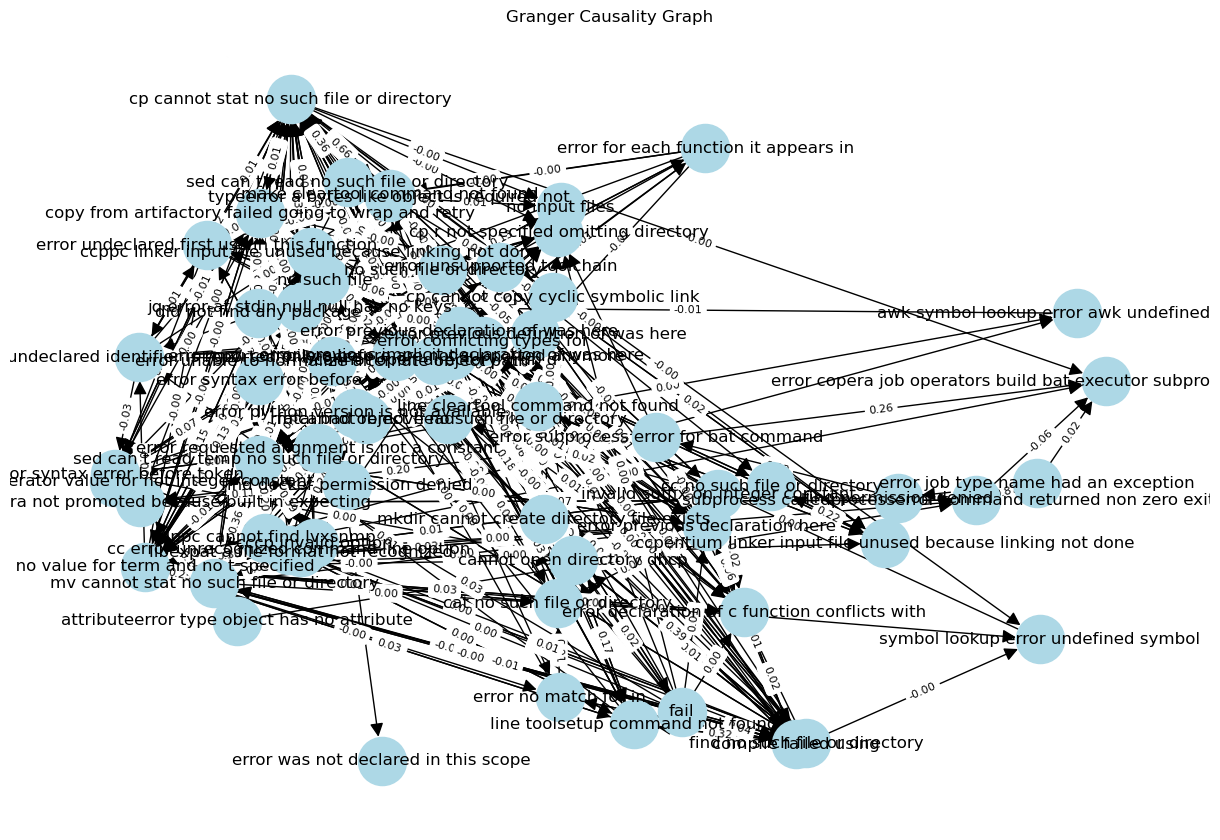

In [2]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from causallearn.search.Granger.Granger import Granger
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# ---------------------------
# 1️⃣ Ler logs
# ---------------------------
def read_log_lines(log_path):
    with open(log_path, 'r') as f:
        return [line.strip() for line in f if line.strip()]

# ---------------------------
# 2️⃣ Transformar logs em série temporal binária
# ---------------------------
def logs_to_time_series(log_lines, min_freq=5):
    counts = Counter(log_lines)
    frequent_templates = {tpl for tpl, freq in counts.items() if freq >= min_freq}
    filtered_lines = [line if line in frequent_templates else None for line in log_lines]

    if len(frequent_templates) == 0:
        raise ValueError("Nenhum template sobreviveu ao filtro de frequência.")

    # One-hot encode temporal
    mlb = MultiLabelBinarizer()
    binary_matrix = mlb.fit_transform([[line] if line is not None else [] for line in filtered_lines])
    df = pd.DataFrame(binary_matrix, columns=mlb.classes_)

    return df, mlb.classes_

# ---------------------------
# 3️⃣ Rodar Granger multivariado
# ---------------------------
def run_multivar_granger(df, variable_names, csv_path="granger_result.csv", report_path="granger_report.txt", alpha=0.01, maxlag=3):
    X = df.to_numpy().astype(float)
    n_vars = len(variable_names)

    G = Granger(maxlag=maxlag)
    coeff_matrix = G.granger_lasso(X)  # multivariado direto

    directed = []
    for i in range(n_vars):
        for j in range(n_vars):
            if i == j:
                continue
            coeff = coeff_matrix[i, j]
            if abs(coeff) > 1e-6:  # considerar como causalidade
                directed.append((variable_names[j], variable_names[i], coeff))

    df_all = pd.DataFrame(directed, columns=["source", "target", "coefficient"])
    df_all.to_csv(csv_path, index=False)

    with open(report_path, 'w') as f:
        f.write("=== Relatório de Granger Causality (Multivariado) ===\n")
        f.write(f"Total de variáveis analisadas: {n_vars}\n")
        f.write(f"Número de relações causais detectadas: {len(directed)}\n")
        f.write(f"\nCSV salvo em: {csv_path}\n")

    print(f"💾 Arquivo CSV salvo em: {csv_path}")
    print(f"📝 Relatório salvo em: {report_path}")
    return df_all, coeff_matrix

# ---------------------------
# 4️⃣ Plotar grafo de causalidade
# ---------------------------
def plot_granger_graph(df_all, title="Granger Causality Graph"):
    G = nx.DiGraph()
    for _, row in df_all.iterrows():
        G.add_edge(row["source"], row["target"], weight=row["coefficient"])

    pos = nx.spring_layout(G, seed=42)
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=1200, node_color="lightblue", arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(title)
    plt.show()

# ---------------------------
# 5️⃣ Pipeline principal
# ---------------------------
log_path = "logs/part_221.log"
csv_path = "relacoes_granger221.csv"
report_path = "relatorio_granger221.txt"
alpha = 0.01
maxlag = 3

# Ler logs
log_lines = read_log_lines(log_path)

# Criar série temporal
df, variable_names = logs_to_time_series(log_lines, min_freq=5)
print(f"📊 Série temporal criada: {df.shape[0]} timestamps × {df.shape[1]} eventos únicos")

# Rodar Granger multivariado
df_result, coeff_matrix = run_multivar_granger(df, variable_names, csv_path, report_path, alpha, maxlag)

# Plotar grafo
plot_granger_graph(df_result)
